# Using M2M: Programmatic Interaction with OOI Data & Metadata
Author: Andrew Reed

### Purpose
This notebook is the companion to the presentation "**Using M2M: Programmatic Interaction with OOI Data & Metadata**" presented as part of the Ocean Observatories Facilities Board **NE Pacific Community Workshop** in Portland, Oregon, from June 7 - 9, 2022. The goal is to walk through how to use the Ocean Observatories Initiative's API, named Machine-2-Machine (M2M), system and examine what data can be queried and how to manipulate it to extract desired information. The table below outlines the different categories of data which can be queried, their access points in the API, and a short description.

| Category | Access Point | Description |
| -------- | ------------ | ----------- |
| Deployment | 12587/events/deployment/inv/ | Access deployment numbers as well as the asset & calibration info for specified instrument & deployment, and deployment times/cruises |
| Deployment | 12587/asset/deployments | Asset & calibration info for all deployment for the specified UID |
| Calibration | /12587/asset/cal?uid= OR ?assetid= | Return all calibration info for a given uid or assetId |
| Calibration | /12587/asset/cal?refdes= | Return list of deployments with calibrations for a given reference designator |
| Asset | 12587/asset?uid= OR ?serialnumber= | Asset information by unique id or instrument serial number |
| Preload | 12575/parameter/ | Retrieve information for a parameter (i.e. variable) given its ID number |
| Preload | 12575/stream/byname/ | Retrieve information for a stream given its name |
| Annotations | /12580/anno/find?= | Retrieve annotations for a specific time period and for a given reference designator (optional: stream and method) |
| Vocab | 12586/vocab/inv/ | Get the vocabulary (descriptions) for a sensor |
| Data | 12576/sensor/inv/ | Can access the data from OOI using either a synchronous (returns JSON; limited to 20000 data points) or asynchronous (returns netCDF, CSV, or JSON; not data limit) |

The tutorial and presentation are based off of similar work developed by Sage Lichtenwalder (github: @seagrinch) for the 2018 OOI Data Workshops. 

### Setup
First, please go to https://ooinet.oceanobservatories.org/ and make an account for yourself. Once you have registered and logged in, navigate to your account settings by clicking on "User Profile" under your email in the top right corner of your screen. Once at your Profile, record your API Username and API Token. These are necessary if you wish to access and download data from the Ocean Observatories API.

Additionally, this notebook makes use of the code contained in the partner module pyOOI. A stripped-down version of this package has been included as a module in the repository with this tutorial to allow for direct import. Further code scripts and functions may also be found on github.com/oceanobservatories/ooi-data-explorations. 

In [1]:
import os, sys
import yaml
import datetime
import requests
import pandas as pd
import xarray as xr
import warnings
warnings.filterwarnings("ignore")

In [2]:
from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

Import the M2M module from the accompanying package if it is downloaded locally:

In [3]:
sys.path.append("../src/")
from pyOOI.M2M import *

In [4]:
for key in URLS.keys():
    dtype = key
    url = URLS.get(dtype)
    print(dtype + " :: " + url)

data :: https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv
anno :: https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find
vocab :: https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv
asset :: https://ooinet.oceanobservatories.org/api/m2m/12587
deploy :: https://ooinet.oceanobservatories.org/api/m2m/12587/events/deployment/inv
preload :: https://ooinet.oceanobservatories.org/api/m2m/12575/parameter
cal :: https://ooinet.oceanobservatories.org/api/m2m/12587/asset/cal
fileServer :: https://opendap.oceanobservatories.org/thredds/fileServer/
dodsC :: https://opendap.oceanobservatories.org/thredds/dodsC/
goldCopy :: https://thredds.dataexplorer.oceanobservatories.org/thredds/catalog/ooigoldcopy/public/
goldCopy_fileServer :: https://thredds.dataexplorer.oceanobservatories.org/thredds/fileServer/
goldCopy_dodsC :: https://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/


---
## Navigating the API
Navigating the OOI M2M end-points can be confusing. We can reference the helpful OOI API cheat-sheet. There are also several other quirks with how OOI delivers data. First, some queries to OOI will return . These are some basic functions needed to interoperate with the OOI data

In [5]:
def ntp_seconds_to_datetime(ntp_seconds):
    """Convert OOINet timestamps to unix-convertable timestamps."""
    # Specify some constant needed for timestamp conversions
    ntp_epoch = datetime.datetime(1900, 1, 1)
    unix_epoch = datetime.datetime(1970, 1, 1)
    ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta)

def convert_time(ms):
    if ms is None:
        return None
    else:
        return datetime.datetime.utcfromtimestamp(ms/1000)

def unix_epoch_time(date_time):
    """Convert a datetime to unix epoch microseconds."""
    # Convert the date time to a string
    date_time = int(pd.to_datetime(date_time).strftime("%s"))*1000
    return date_time

---
## Finding Data

The first step in downloading data from the OOI M2M is to find the datasets that you want to download. We can do this by querying the "data" API through its various endpoints until we have the sensor that we are interested in.

In [6]:
# Start with the basic - just requesting the very basic gives you a list of the available sites - OOI parlance
# for the different moorings (i.e. Global Station Papa Flanking Mooring A = GP03FLMA)
print("API Endpoint: " + URLS["data"] + "\n")

print("Returns the following list of sites: \n")
sites = get_api(URLS["data"])
print(sites)

API Endpoint: https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv

Returns the following list of sites: 

['CE01ISSM', 'CE01ISSP', 'CE02SHBP', 'CE02SHSM', 'CE02SHSP', 'CE04OSBP', 'CE04OSPD', 'CE04OSPI', 'CE04OSPS', 'CE04OSSM', 'CE05MOAS', 'CE06ISSM', 'CE06ISSP', 'CE07SHSM', 'CE07SHSP', 'CE09OSPM', 'CE09OSSM', 'CP01CNPM', 'CP01CNSM', 'CP01CNSP', 'CP02PMCI', 'CP02PMCO', 'CP02PMUI', 'CP02PMUO', 'CP03ISPM', 'CP03ISSM', 'CP03ISSP', 'CP04OSPM', 'CP04OSSM', 'CP05MOAS', 'GA01SUMO', 'GA02HYPM', 'GA03FLMA', 'GA03FLMB', 'GA05MOAS', 'GI01SUMO', 'GI02HYPM', 'GI03FLMA', 'GI03FLMB', 'GI05MOAS', 'GP02HYPM', 'GP03FLMA', 'GP03FLMB', 'GP05MOAS', 'GS01SUMO', 'GS02HYPM', 'GS03FLMA', 'GS03FLMB', 'GS05MOAS', 'RS01OSBP', 'RS01SBPD', 'RS01SBPS', 'RS01SHBP', 'RS01SHDR', 'RS01SLBS', 'RS01SUM1', 'RS01SUM2', 'RS03ASHS', 'RS03AXBS', 'RS03AXPD', 'RS03AXPS', 'RS03AXSM', 'RS03CCAL', 'RS03ECAL', 'RS03INT1', 'RS03INT2', 'SSRSPACC']


In [7]:
# Select a site: Global Flanking Mooring A
site = "GP03FLMA"

# Can further narrow down the search - adding in the site will generate a list of the "nodes" on the mooring
print("API Endpoint: " + URLS["data"] + "/" + site + "\n")

print(f"Returns the following list of nodes on {site}: \n")
nodes = get_api(URLS["data"] + "/" + site)
print(nodes)

API Endpoint: https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/GP03FLMA

Returns the following list of nodes on GP03FLMA: 

['RIM01', 'RIS01']


In [8]:
# Select a node - in this case the Mooring Riser
node = "RIS01"

# Can further narrow the search - adding in the node with generate a list of the sensors on the given platform and node
print("API Endpoint: " + URLS["data"] + "/" + site + "/" + node + "\n")

# Next, we can get all of the sensors on a given mooring node
print(f"Returns the following list of sensors on {site}-{node}: \n")
sensors = get_api(URLS["data"] + "/" + site + "/" + node)
print(sensors)

API Endpoint: https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/GP03FLMA/RIS01

Returns the following list of sensors on GP03FLMA-RIS01: 

['00-SIOENG000', '03-DOSTAD000', '04-PHSENF000', '05-FLORTD000']


Here we can see there are four sensors on the Global Flanking Mooring A - Riser. One of the sensors (00-SIOENG000) returns engineering/operations data and does not have useful science data. The other three sensors are:
* 03-DOSTAD000 - oxygen sensor
* 04-PHSENF000 - pH sensor
* 05-FLORTD000 - chlorophyll/turbidity sensor

In [9]:
# Select a sensor - in this case the dissolved oxygen sensor
sensor = "03-DOSTAD000"

# With the site-node-sensors we can construct a "reference designator" or refdes for short
print(f"Site: {site}")
print(f"Node: {node}")
print(f"Sensor: {sensor}")

Site: GP03FLMA
Node: RIS01
Sensor: 03-DOSTAD000


With the **site**, **node**, and **sensor** we can construct the **reference designator** or **refdes** for short. The **reference designator** identifies a particular instrument that has been deployed as part of a site.

In [10]:
refdes = "-".join((site, node, sensor))
print(f"Reference Designator: {refdes}")
print(f"Site: {site}")
print(f"Node: {node}")
print(f"Sensor: {sensor}")

Reference Designator: GP03FLMA-RIS01-03-DOSTAD000
Site: GP03FLMA
Node: RIS01
Sensor: 03-DOSTAD000


In [11]:
# With a sensor selected, we can see what data delivery methods are available
print("API Endpoint: " + URLS["data"] + "/" + site + "/" + node + "/" + sensor + "\n")

# Next, we can get all of the sensors on a given mooring node
print(f"Returns the following list of data delivery methods on {site}-{node}-{sensor}: \n")
methods = get_api(URLS["data"] + "/" + site + "/" + node + "/" + sensor)
print(methods)

API Endpoint: https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/GP03FLMA/RIS01/03-DOSTAD000

Returns the following list of data delivery methods on GP03FLMA-RIS01-03-DOSTAD000: 

['recovered_host', 'telemetered']


The **Data Delivery Method** specifies how the data was either transmitted or recorded. In this case, we have the options:
* **recovered_host**: Data downloaded directly from the computer on the mooring or asset which logs the data from the attached instruments
* **telemetered**: Data received through wireless transmission, e.g. surface buoy to satellite, glider to satellite, etc. Telemetered data is frequently truncated or decimated to reduce size for transmission.

In [12]:
# Select a data delivery method
method = "recovered_host"

# Can further narrow the search - adding in the node with generate a list of the sensors on the given platform and node
print("API Endpoint: " + URLS["data"] + "/" + site + "/" + node + "/" + sensor + "/" + method + "\n")

# Next, we can get all of the sensors on a given mooring node
print(f"Returns the following list of streams for {site}-{node}-{sensor} {method}: \n")
sensors = get_api(URLS["data"] + "/" + site + "/" + node + "/" + sensor + "/" + method)
print(sensors)

API Endpoint: https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/GP03FLMA/RIS01/03-DOSTAD000/recovered_host

Returns the following list of streams for GP03FLMA-RIS01-03-DOSTAD000 recovered_host: 

['dosta_abcdjm_sio_instrument_recovered', 'dosta_abcdjm_sio_metadata_recovered']


The **Data Streams** are generated from parsing the sensor raw data and separating it based on content (e.g. science, engineering, metadata, etc.). In this case, we have the options:
* **dosta_abcdjm_sio_metadata_recovered**: this is the stream which contains metadata and sensor engineering data
* **dosta_abcdjm_sio_instrument_recovered**: this stream contains the science-relevant data we are interested in getting

In [13]:
# Select the stream
stream = "dosta_abcdjm_sio_instrument_recovered"

#### Search Datasets

For your convience, the function ```search_datasets``` included in the tutorial package can search the available OOI Reference Designators (i.e. "refdes" for short) on the following keys: **array**, **node**, **instrument**. Additionally, can request for "**English_names**", which will return the descriptive name for the associated array, node, and instrument. The function uses the knowledge of the sensor endpoints outlined above to crawl through the endpoints looking for available datasets which fit the search keys. Below, we will search for the available CTD instruments on the Global Ocean Station Papa Flanking Mooring A. Adding the "**English_names**" make use of the **vocab** url which we'll explore in a section lower-down in this notebook.

The major caveat with the search is, similar to when searching on ERDDAP datasets, the search terms must be partial or full match based on OOI nomenclature. For example, if we were looking for CTDs, we would have to search for "CTD", "CTDMO", or the full instrument name "02-CTDMOH051". We can't search "conductivity", "temperature" or other CTD-related instrument terms.

We'll search the Global Ocean Station Papa Flanking Mooring A Datasets for any oxygen sensors, all of which will start with "DO".

In [14]:
papa_datasets = search_datasets(array="GP03FLMA", instrument="DO", English_names=True)
papa_datasets

Output()

,array,array_name,node,node_name,instrument,instrument_name,refdes,url,deployments
0,GP03FLMA,Global Station Papa Flanking Subsurface Mooring A,RIS01,Mooring Riser,03-DOSTAD000,Dissolved Oxygen,GP03FLMA-RIS01-03-DOSTAD000,https://ooinet.oceanobservatories.org/api/m2m/...,"[1, 2, 3, 4, 5, 6, 7, 8, 9]"


You will still need to query the M2M API to get the available methods and data streams for the reference designator that you choose.

Now, we could go ahead and request data for the Global Ocean Station Papa Mooring Riser Dissolved Oxygen Sensor by using the API Endpoint https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/GP03FLMA/RIS01/03-DOSTAD000/recovered_host/dosta_abcdjm_sio_instrument_recovered. However, this request will return _all_ of the available data and _all_ of the parameters for the sensor, including a lot of engineering or unprocessed data.

Instead, we can interrogate the OOI M2M system to get information on when the sensor has been deployed, what parameters are available on what data streams, and start to narrow our data request to only those parameters, time periods, and/or deployments that we may be interested in.

---
## Deployment Information
A deployment is defined as the span of time a mooring or instrument were deployed and then recovered. When we searched for the dissolved oxygen sensor on the Global Ocean Station Papa Flanking Mooring A, it returned a table which listed the available deployment numbers for each of the datasets. We can get much more detailed information on the deployments for a particular reference designator by requesting the deployment information from OOINet. 

We can start by using the deployment endpoint and reference designator to get a list of the available deployments for the reference designator:

In [15]:
refdes = "GP03FLMA-RIS01-03-DOSTAD000"
site, node, sensor = refdes.split("-", 2)

In [16]:
# First, we can request the deployment numbers for the given site-node-stream
print("API Endpoint: " + "/".join((URLS["deploy"], site, node, sensor)) + "\n")
print(get_api("/".join((URLS["deploy"], site, node, sensor))))

API Endpoint: https://ooinet.oceanobservatories.org/api/m2m/12587/events/deployment/inv/GP03FLMA/RIS01/03-DOSTAD000

[1, 2, 3, 4, 5, 6, 7, 8, 9]


If we want more detailed information about a given deployment, we need to add in the deployment number:

In [17]:
# Returns asset and calibration information for deployment
deployment_number = "5"
data = get_api("/".join((URLS["deploy"], site, node, sensor, deployment_number)))
data

[{'@class': '.XDeployment',
  'lastModifiedTimestamp': 1653401676847,
  'dataSource': 'Load from [GP03FLMA_Deploy.xlsx]',
  'eventName': 'GP03FLMA-RIS01-03-DOSTAD000',
  'eventType': 'DEPLOYMENT',
  'eventStartTime': 1499986800000,
  'eventStopTime': 1532620260000,
  'notes': None,
  'eventId': 9514,
  'assetUid': None,
  'deployCruiseInfo': {'@class': '.CruiseInfo',
   'lastModifiedTimestamp': 1653401064310,
   'dataSource': 'Load from [CruiseInformation.xlsx]',
   'eventName': 'SR1710',
   'eventType': 'CRUISE_INFO',
   'eventStartTime': 1499468400000,
   'eventStopTime': 1500752700000,
   'notes': None,
   'eventId': 107,
   'assetUid': None,
   'uniqueCruiseIdentifier': 'SR1710',
   'shipName': 'Sally Ride',
   'editPhase': 'OPERATIONAL',
   'cruiseIdentifier': None,
   'tense': 'UNKNOWN'},
  'recoverCruiseInfo': {'@class': '.CruiseInfo',
   'lastModifiedTimestamp': 1653401064374,
   'dataSource': 'Load from [CruiseInformation.xlsx]',
   'eventName': 'SR1811',
   'eventType': 'CRUI

This returns a json object with a dictionary that contains a lot of very, very detailed information. Depending on what you want, this has to be parsed out. Since we are interested in deployment information, lets
parse that relevant info such as deployment start/end times, the unique ID of the instrument deployed, what cruise it was deployed on, etc:

In [18]:
deploymentInfo = pd.DataFrame()
for d in data: # If you requested more than one deployment
    deploymentInfo = deploymentInfo.append( {
        "deploymentNumber": d.get("deploymentNumber"),
        "referenceDesignator": d.get("referenceDesignator"),
        "mooring": d.get("mooring").get("description"),
        "sensor": d.get("sensor").get("description"),
        "UID": d.get("sensor").get("uid"),
        "deployDateTime": convert_time(d.get("eventStartTime")).strftime("%Y-%m-%dT%H:%M:%SZ"),
        "recoverDateTime": convert_time(d.get("eventStopTime")).strftime("%Y-%m-%dT%H:%M:%SZ"),
        "deployCruise": d.get("deployCruiseInfo").get("eventName"),
        "recoverCruise": d.get("recoverCruiseInfo").get("eventName")
    }, ignore_index=True)
    
deploymentInfo

,deploymentNumber,referenceDesignator,mooring,sensor,UID,deployDateTime,recoverDateTime,deployCruise,recoverCruise
0,5,GP03FLMA-RIS01-03-DOSTAD000,Global Station Papa Flanking Subsurface Mooring A,Dissolved Oxygen Stable Response: DOSTA Series D,CGINS-DOSTAD-00129,2017-07-13T23:00:00Z,2018-07-26T15:51:00Z,SR1710,SR1811


The included function in the tutorial package ```get_deployments``` takes a reference designator, i.e. GP03FLMA-RIS01-02-DOSTAD000, parses it into the {site}/{node}/{sensor} information, and fetches all of the available info on the deployments for the given reference designator and returns it as a pandas dataframe.

In [19]:
deployments = get_deployments(refdes)
deployments

,deploymentNumber,uid,assetId,latitude,longitude,depth,deployStart,deployEnd,deployCruise,recoverCruise
0,1,CGINS-DOSTAD-00129,2379,49.9795,-144.254,28.0,2013-07-21 22:44:00,2014-06-15 17:30:00,MV1309,MV1404
1,2,CGINS-DOSTAD-00127,2383,49.9775,-144.2463,28.0,2014-06-18 05:56:00,2015-06-05 14:53:00,MV1404,TN323
2,3,CGINS-DOSTAD-00394,3655,49.97667,-144.24617,28.0,2015-06-06 22:40:00,2016-06-28 15:02:00,TN323,RB1605
3,4,CGINS-DOSTAD-00130,2414,49.97434,-144.23972,30.0,2016-07-01 01:07:00,2017-07-18 15:13:00,RB1605,SR1710
4,5,CGINS-DOSTAD-00129,2379,50.02288,-144.36125,30.0,2017-07-13 23:00:00,2018-07-26 15:51:00,SR1710,SR1811
5,6,CGINS-DOSTAD-00228,2501,49.976145,-144.246335,30.0,2018-07-23 22:54:00,2019-09-29 15:54:00,SR1811,SKQ201920S
6,7,CGINS-DOSTAD-00379,3753,50.0227,-144.360783,30.0,2019-09-29 04:40:00,2021-07-26 18:24:00,SKQ201920S,SKQ202111S
7,8,CGINS-DOSTAD-00377,3757,49.977455,-144.244048,30.0,2021-07-23 19:43:00,None,SKQ202111S,None
8,9,CGINS-DOSTAD-00439,1209,50.02187,-144.359633,30.0,2022-05-19 17:27:00,None,SKQ202208S,None


---
## Vocab Information
Additionally, if we are interested in more detailed information on the location that the reference designator is assigned to, we can request the vocab information for the given reference designator. The request returns a JSON object with details on the instrument such as the descriptive names for the reference designator location, the nominal depths, the manufacturer as well as the instrument model, etc. The vocab information includes some of the "**English_names**" info we requested when searching for datasets.

In [20]:
vocab_url = "/".join((URLS["vocab"], site, node, sensor))
print(vocab_url + "\n") 

vocab = get_api(vocab_url)
vocab

https://ooinet.oceanobservatories.org/api/m2m/12586/vocab/inv/GP03FLMA/RIS01/03-DOSTAD000



[{'@class': '.VocabRecord',
  'vocabId': 1292,
  'refdes': 'GP03FLMA-RIS01-03-DOSTAD000',
  'instrument': 'Dissolved Oxygen',
  'tocL1': 'Global Station Papa',
  'tocL2': 'Flanking Subsurface Mooring A',
  'tocL3': 'Mooring Riser',
  'manufacturer': 'Aanderaa',
  'model': 'Optode 4831',
  'mindepth': 30.0,
  'maxdepth': 30.0}]

The included function ```get_vocab``` performs the request and reformats the JSON object into a pandas dataframe

In [21]:
vocab = get_vocab(refdes)
vocab

,@class,vocabId,refdes,instrument,tocL1,tocL2,tocL3,manufacturer,model,mindepth,maxdepth
0,.VocabRecord,1292,GP03FLMA-RIS01-03-DOSTAD000,Dissolved Oxygen,Global Station Papa,Flanking Subsurface Mooring A,Mooring Riser,Aanderaa,Optode 4831,30.0,30.0


---
## Calibration Information
We can also request the calibration information for a given reference designator. Since individual instruments are swapped during each mooring deployment & recovery, the calibration coefficients for a reference designator are different for each deployment. The way OOI operates is that it loads all the available calibration coefficients for a given reference designator. Then, for each deployment, it finds the calibration coefficients with the most recent calibration date which most closely _precedes_ the start of the deployment. The result is a table, sorted by deployment number for a reference designator, with the uid of the specific instrument, its calibration coefficients, when the instrument was calibrated, and the source of the calibration coefficients.

In [22]:
cal_url = URLS["cal"] + "?refdes=" + refdes
print(cal_url + "\n")

cal_data = get_api(cal_url)
cal_data

https://ooinet.oceanobservatories.org/api/m2m/12587/asset/cal?refdes=GP03FLMA-RIS01-03-DOSTAD000



[{'@class': '.XDeployment',
  'lastModifiedTimestamp': 1653401676548,
  'dataSource': 'Load from [GP03FLMA_Deploy.xlsx]',
  'eventName': 'GP03FLMA-RIS01-03-DOSTAD000',
  'eventType': 'DEPLOYMENT',
  'eventStartTime': 1374446640000,
  'eventStopTime': 1402853400000,
  'notes': None,
  'eventId': 9442,
  'assetUid': None,
  'deployCruiseInfo': {'@class': '.CruiseInfo',
   'lastModifiedTimestamp': 1653401064156,
   'dataSource': 'Load from [CruiseInformation.xlsx]',
   'eventName': 'MV1309',
   'eventType': 'CRUISE_INFO',
   'eventStartTime': 1373914800000,
   'eventStopTime': 1375225200000,
   'notes': None,
   'eventId': 3,
   'assetUid': None,
   'uniqueCruiseIdentifier': 'MV1309',
   'shipName': 'Melville',
   'editPhase': 'OPERATIONAL',
   'cruiseIdentifier': None,
   'tense': 'UNKNOWN'},
  'recoverCruiseInfo': {'@class': '.CruiseInfo',
   'lastModifiedTimestamp': 1653401064167,
   'dataSource': 'Load from [CruiseInformation.xlsx]',
   'eventName': 'MV1404',
   'eventType': 'CRUISE_I

In [23]:
len(cal_data)

9

We can see that the returned JSON object has multiple entries. Since individual instruments are swapped during each mooring deployment & recovery, the calibration coefficients for a reference designator are different for each deployment. The way OOI operates is that it loads all the available calibration coefficients for a given reference designator. Then, for each deployment, it finds the calibration coefficients with the most recent calibration date which most closely _precedes_ the start of the deployment, and applies those for the given deployment. 

However, when going through each entry, you'll notice that each deployment entry has all of the calibrations in the system entered for that given instrument UID. This makes parsing it very confusing. A better approach is to limit your request to a single deployment or even a single day by adding in **beginDT** and **endDT** to the request. 

In [24]:
# Limit the request to Deployment 6: summer of 2018 to summer of 2019
beginDT = "2018-08-29T22:54:00.000Z"
endDT = "2018-08-30T22:54:00.000Z"

# 
cal_url = URLS["cal"] + "?refdes=" + refdes + "&beginDT=" + beginDT + "&endDT=" + endDT
print("API Endpoint: " + cal_url + "\n")

cal_data = get_api(cal_url)
cal_data

API Endpoint: https://ooinet.oceanobservatories.org/api/m2m/12587/asset/cal?refdes=GP03FLMA-RIS01-03-DOSTAD000&beginDT=2018-08-29T22:54:00.000Z&endDT=2018-08-30T22:54:00.000Z



[{'@class': '.XDeployment',
  'lastModifiedTimestamp': 1653401676921,
  'dataSource': 'Load from [GP03FLMA_Deploy.xlsx]',
  'eventName': 'GP03FLMA-RIS01-03-DOSTAD000',
  'eventType': 'DEPLOYMENT',
  'eventStartTime': 1532386440000,
  'eventStopTime': 1569772440000,
  'notes': None,
  'eventId': 9532,
  'assetUid': None,
  'deployCruiseInfo': {'@class': '.CruiseInfo',
   'lastModifiedTimestamp': 1653401064374,
   'dataSource': 'Load from [CruiseInformation.xlsx]',
   'eventName': 'SR1811',
   'eventType': 'CRUISE_INFO',
   'eventStartTime': 1531868400000,
   'eventStopTime': 1533357000000,
   'notes': None,
   'eventId': 152,
   'assetUid': None,
   'uniqueCruiseIdentifier': 'SR1811',
   'shipName': 'Sally Ride',
   'editPhase': 'OPERATIONAL',
   'cruiseIdentifier': None,
   'tense': 'UNKNOWN'},
  'recoverCruiseInfo': {'@class': '.CruiseInfo',
   'lastModifiedTimestamp': 1653401064450,
   'dataSource': 'Load from [CruiseInformation.xlsx]',
   'eventName': 'SKQ201920S',
   'eventType': '

Now we can parse the JSON file to get the relevant calibration information for the DOSTA instrument deployed at Global Ocean Station Papa for deployment number 6:

In [25]:
calibrations = pd.DataFrame()
for c in cal_data:
    deploymentNumber = c.get("deploymentNumber")
    uid = c.get("sensor").get("uid")
    for cc in c.get("sensor").get("calibration"):
        for ccc in cc.get("calData"):
            name = ccc.get("eventName")
            value = ccc.get("value")
            source = ccc.get("dataSource")
            # Update the calibration data frame
            calibrations = calibrations.append({
                "deploymentNumber": deploymentNumber,
                "uid": uid,
                "calCoef": name,
                "value": value,
                "calFile": source,
            }, ignore_index=True)
            
calibrations

,deploymentNumber,uid,calCoef,value,calFile
0,6,CGINS-DOSTAD-00228,CC_conc_coef,"[-0.5159482, 0.9981074]",CGINS-DOSTAD-00228__20170918_Cal_Info.xlsx
1,6,CGINS-DOSTAD-00228,CC_csv,"[0.00289589, 0.000120386, 2.34238e-06, 233.068...",CGINS-DOSTAD-00228__20170918_Cal_Info.xlsx


The function ```get_calibrations``` included in this tutorial drastically simplifies the requests. However, it does need the **deployment** information fetched using the ```get_deployments``` function. What is nice about the function is that it will return the calibrations applicable for each deployment and just that deployment.

In [26]:
calibrations = get_calibrations_by_refdes(refdes, deployments)
calibrations

,deploymentNumber,uid,calCoef,value,calFile
0,1,CGINS-DOSTAD-00129,CC_conc_coef,"[0.0, 1.0]",CGINS-DOSTAD-00129__20130119_Cal_Info.xlsx
1,1,CGINS-DOSTAD-00129,CC_csv,"[0.00275578, 0.000114513, 2.1867e-06, 235.515,...",CGINS-DOSTAD-00129__20130119_Cal_Info.xlsx
2,2,CGINS-DOSTAD-00127,CC_conc_coef,"[0.0, 1.0]",CGINS-DOSTAD-00127__20130117_Cal_Info.xlsx
3,2,CGINS-DOSTAD-00127,CC_csv,"[0.00271575, 0.000112342, 2.28877e-06, 233.504...",CGINS-DOSTAD-00127__20130117_Cal_Info.xlsx
4,3,CGINS-DOSTAD-00394,CC_conc_coef,"[0.0, 1.0]",CGINS-DOSTAD-00394__20140620_Cal_Info.xlsx
5,3,CGINS-DOSTAD-00394,CC_csv,"[0.00284877, 0.000120979, 2.43655e-06, 230.03,...",CGINS-DOSTAD-00394__20140620_Cal_Info.xlsx
6,4,CGINS-DOSTAD-00130,CC_conc_coef,"[0.0, 1.0]",CGINS-DOSTAD-00130__20160126_Cal_Info.xlsx
7,4,CGINS-DOSTAD-00130,CC_csv,"[0.00253971, 0.000107782, 2.20778e-06, 228.653...",CGINS-DOSTAD-00130__20160126_Cal_Info.xlsx
8,5,CGINS-DOSTAD-00129,CC_conc_coef,"[0.0, 1.0]",CGINS-DOSTAD-00129__20151206_Cal_Info.xlsx
9,5,CGINS-DOSTAD-00129,CC_csv,"[0.00275912, 0.000116599, 2.28573e-06, 232.226...",CGINS-DOSTAD-00129__20151206_Cal_Info.xlsx


It is much easier to query for calibration data by the UID, or unique ID, for an instrument. For example, if we are looking at the oxygen optode deployed for Deployment 6, it has a UID of CGINS-DOSTAD-00228. We can request the calibration coefficients for that particular instrument.

In [27]:
# Set up the calibration url and arguments to pass to the request
uid = "CGINS-DOSTAD-00228" # This is unique to each instrument
cal_url = URLS["cal"] + "?uid=" + uid
print("API Endpoint: " + cal_url)

# Make the request
calInfo = get_api(cal_url)

# Put the data into a pandas dataframe, sorted by calibration date and coefficient name
columns = ["uid", "calCoef", "calDate", "value", "calFile"]
instrumentCals = pd.DataFrame(columns=columns)
for c in calInfo["calibration"]:
    for cc in c["calData"]:
        instrumentCals = instrumentCals.append({
            "uid": cc["assetUid"],
            "calCoef": cc["eventName"],
            "calDate": convert_time(cc["eventStartTime"]),
            "value": cc["value"],
            "calFile": cc["dataSource"]
        }, ignore_index=True)
instrumentCals.sort_values(by=["calDate", "calCoef"], inplace=True)
instrumentCals

API Endpoint: https://ooinet.oceanobservatories.org/api/m2m/12587/asset/cal?uid=CGINS-DOSTAD-00228


,uid,calCoef,calDate,value,calFile
2,CGINS-DOSTAD-00228,CC_conc_coef,2013-08-04 00:00:00,"[0.0, 1.0]",CGINS-DOSTAD-00228__20130804_Cal_Info.xlsx
4,CGINS-DOSTAD-00228,CC_csv,2013-08-04 00:00:00,"[0.00313162, 0.000129918, 2.61329e-06, 233.397...",CGINS-DOSTAD-00228__20130804_Cal_Info.xlsx
0,CGINS-DOSTAD-00228,CC_conc_coef,2016-02-26 00:00:00,"[0.0, 1.0]",CGINS-DOSTAD-00228__20160226_Cal_Info.xlsx
3,CGINS-DOSTAD-00228,CC_csv,2016-02-26 00:00:00,"[0.00289589, 0.000120386, 2.34238e-06, 233.068...",CGINS-DOSTAD-00228__20160226_Cal_Info.xlsx
1,CGINS-DOSTAD-00228,CC_conc_coef,2017-09-18 00:00:00,"[-0.5159482, 0.9981074]",CGINS-DOSTAD-00228__20170918_Cal_Info.xlsx
5,CGINS-DOSTAD-00228,CC_csv,2017-09-18 00:00:00,"[0.00289589, 0.000120386, 2.34238e-06, 233.068...",CGINS-DOSTAD-00228__20170918_Cal_Info.xlsx


Similiarly, there is an included function ```get_calibrations_by_uid```

In [28]:
get_calibrations_by_uid("CGINS-DOSTAD-00228")

,uid,calCoef,calDate,value,calFile
2,CGINS-DOSTAD-00228,CC_conc_coef,2013-08-04 00:00:00,"[0.0, 1.0]",CGINS-DOSTAD-00228__20130804_Cal_Info.xlsx
4,CGINS-DOSTAD-00228,CC_csv,2013-08-04 00:00:00,"[0.00313162, 0.000129918, 2.61329e-06, 233.397...",CGINS-DOSTAD-00228__20130804_Cal_Info.xlsx
0,CGINS-DOSTAD-00228,CC_conc_coef,2016-02-26 00:00:00,"[0.0, 1.0]",CGINS-DOSTAD-00228__20160226_Cal_Info.xlsx
3,CGINS-DOSTAD-00228,CC_csv,2016-02-26 00:00:00,"[0.00289589, 0.000120386, 2.34238e-06, 233.068...",CGINS-DOSTAD-00228__20160226_Cal_Info.xlsx
1,CGINS-DOSTAD-00228,CC_conc_coef,2017-09-18 00:00:00,"[-0.5159482, 0.9981074]",CGINS-DOSTAD-00228__20170918_Cal_Info.xlsx
5,CGINS-DOSTAD-00228,CC_csv,2017-09-18 00:00:00,"[0.00289589, 0.000120386, 2.34238e-06, 233.068...",CGINS-DOSTAD-00228__20170918_Cal_Info.xlsx


---
## Metadata
Next, we can query OOINet for the metadata associated with the selected reference designator. The metadata contains such valuable information such as the available **methods** and **streams** (which are required to download the data), the **particleKeys** (the data variable names), and the associated **units**. 

In [29]:
metadata = get_metadata(refdes)
metadata

,pdId,particleKey,type,shape,units,fillValue,stream,unsigned,method,count,beginTime,endTime,refdes
0,PD7,time,DOUBLE,SCALAR,seconds since 1900-01-01,-9999999,dosta_abcdjm_sio_instrument,False,telemetered,3914,2014-06-18T08:00:01.000Z,2020-01-23T16:00:01.000Z,GP03FLMA-RIS01-03-DOSTAD000
1,PD10,port_timestamp,DOUBLE,SCALAR,seconds since 1900-01-01,-9999999,dosta_abcdjm_sio_instrument,False,telemetered,3914,2014-06-18T08:00:01.000Z,2020-01-23T16:00:01.000Z,GP03FLMA-RIS01-03-DOSTAD000
2,PD11,driver_timestamp,DOUBLE,SCALAR,seconds since 1900-01-01,-9999999,dosta_abcdjm_sio_instrument,False,telemetered,3914,2014-06-18T08:00:01.000Z,2020-01-23T16:00:01.000Z,GP03FLMA-RIS01-03-DOSTAD000
3,PD12,internal_timestamp,DOUBLE,SCALAR,seconds since 1900-01-01,-9999999,dosta_abcdjm_sio_instrument,False,telemetered,3914,2014-06-18T08:00:01.000Z,2020-01-23T16:00:01.000Z,GP03FLMA-RIS01-03-DOSTAD000
4,PD14,dissolved_oxygen,FLOAT,FUNCTION,µmol kg-1,-9999999,dosta_abcdjm_sio_instrument,False,telemetered,3914,2014-06-18T08:00:01.000Z,2020-01-23T16:00:01.000Z,GP03FLMA-RIS01-03-DOSTAD000
5,PD16,preferred_timestamp,STRING,SCALAR,1,empty,dosta_abcdjm_sio_instrument,False,telemetered,3914,2014-06-18T08:00:01.000Z,2020-01-23T16:00:01.000Z,GP03FLMA-RIS01-03-DOSTAD000
6,PD863,ingestion_timestamp,DOUBLE,SCALAR,seconds since 1900-01-01,-9999,dosta_abcdjm_sio_instrument,False,telemetered,3914,2014-06-18T08:00:01.000Z,2020-01-23T16:00:01.000Z,GP03FLMA-RIS01-03-DOSTAD000
7,PD940,estimated_oxygen_concentration,FLOAT,SCALAR,µmol L-1,-9999999,dosta_abcdjm_sio_instrument,False,telemetered,3914,2014-06-18T08:00:01.000Z,2020-01-23T16:00:01.000Z,GP03FLMA-RIS01-03-DOSTAD000
8,PD941,estimated_oxygen_saturation,FLOAT,SCALAR,percent,-9999999,dosta_abcdjm_sio_instrument,False,telemetered,3914,2014-06-18T08:00:01.000Z,2020-01-23T16:00:01.000Z,GP03FLMA-RIS01-03-DOSTAD000
9,PD942,optode_temperature,FLOAT,SCALAR,ºC,-9999999,dosta_abcdjm_sio_instrument,False,telemetered,3914,2014-06-18T08:00:01.000Z,2020-01-23T16:00:01.000Z,GP03FLMA-RIS01-03-DOSTAD000


Now, there are a lot of different variables returned in the metadata for the Oxygen sensor. Unless we want to reprocess the raw data ourselves, we really just want the scientifically relevant parameters. But which ones are those?

Level 1, or L1 Data Products, are derived from L0 data, and provide data that has been calibrated using vendor-provided values or values derived from pre-deployment procedures, and that is in scientific units.

Example: Data from Aanderaa oxygen (DOSTA) sensors are converted from the L0 data  (DCONCS_L0) to the L1 dissolved oxygen concentrations data product (DCONCS_L1) internally using the manufacturer’s conversion factors. While this is done onboard of the oxygen optode, the L0 products, such as the amplitude, phase, etc are available if desired.

Level 2, or L2 Data Products are derived quantities created via an algorithm that draws on multiple L1 Data Products. L2 data products may be based on data from the same or a combination of separate instruments. 
Example: Level 1 temperature (TEMPWAT_L1) and salinity (PRACSAL_L1) data products are used in conjunction with the Level 1 nitrate concentration data product to produce a temperature and salinity corrected Level 2 dissolved oxygen concentration data product (DOXYGEN_L2).  

**We recommend that end users work with Level 2 Data Products for analysis**, and use Level 0 and Level 1 products only in cases where the end user has a specific reason requiring these earlier-stage data products for their own data processing needs.

We can query for the relevant data product level from the "Preload Database" using the **pdId** field from the returned metadata. One note of caution: the data levels for some variables such as **time** are set as **None** even though time is a fundamental parameter. 

In [30]:
# Lets query "time" for its data level
preload_url = URLS["preload"] + "/" + "7"
print("API Endpoint: " + preload_url)

get_api(preload_url)

API Endpoint: https://ooinet.oceanobservatories.org/api/m2m/12575/parameter/7


{'name': 'time',
 'display_name': 'Time, UTC',
 'netcdf_name': 'time',
 'standard_name': 'time',
 'description': 'Time, UTC',
 'id': 7,
 'data_product_identifier': None,
 'precision': None,
 'fill_value': {'value': '-9999999'},
 'unit': {'value': 'seconds since 1900-01-01'},
 'data_level': None,
 'code_set': None,
 'value_encoding': {'value': 'float64'},
 'parameter_type': {'value': 'quantity'},
 'parameter_function': None,
 'data_product_type': None,
 'dimensions': [],
 'parameter_function_map': None,
 'visible': True}

In [31]:
# Query the dissolved oxygen
preload_url = URLS["preload"] + "/" + "14"
print("API Endpoint: " + preload_url)

get_api(preload_url)

API Endpoint: https://ooinet.oceanobservatories.org/api/m2m/12575/parameter/14


{'name': 'dissolved_oxygen',
 'display_name': 'DO from Onboard Calculation - Corrected',
 'netcdf_name': 'dissolved_oxygen',
 'standard_name': 'moles_of_oxygen_per_unit_mass_in_sea_water',
 'description': 'Dissolved Oxygen Concentration from the Stable Response Dissolved Oxygen Instrument is a measure of the concentration of gaseous oxygen mixed in seawater. This data product is corrected for salinity, temperature, and depth.',
 'id': 14,
 'data_product_identifier': 'DOXYGEN_L2',
 'precision': 4,
 'fill_value': {'value': '-9999999'},
 'unit': {'value': 'µmol kg-1'},
 'data_level': 2,
 'code_set': None,
 'value_encoding': {'value': 'float32'},
 'parameter_type': {'value': 'function'},
 'parameter_function': {'id': 61,
  'name': 'do2_salinity_correction',
  'function_type': {'value': 'PythonFunction'},
  'function': 'do2_salinity_correction',
  'owner': 'ion_functions.data.do2_functions',
  'description': 'Salinity and pressure correction to dissolved oxygen producing L2 DOCONCS',
  'qc_

From above, we can see that **time** does not have a data level, whereas **dissolved_oxygen** is a **L2** level product. 

The function ```get_parameter_data_levels``` will take in the metadata you requested and return the relevant data levels for the parameter

In [32]:
data_levels = get_parameter_data_levels(metadata)
data_levels

{'PD10': None,
 'PD1005': None,
 'PD11': None,
 'PD12': None,
 'PD14': 2,
 'PD16': None,
 'PD2174': None,
 'PD2843': 1,
 'PD312': None,
 'PD7': None,
 'PD863': None,
 'PD940': 1,
 'PD941': None,
 'PD942': None,
 'PD943': 0,
 'PD944': None,
 'PD945': None,
 'PD946': None,
 'PD947': None,
 'PD948': None,
 'PD949': None}

With the returned parameter IDs, we can now filter for the L1 and L2 data levels:

In [33]:
def filter_science_parameters(metadata, data_levels):
    """This function returns the science parameters for each datastream"""
    
    def filter_parameter_ids(pdId, pid_dict):
        data_level = pid_dict.get(pdId)
        if data_level is not None:
            if data_level > 0:
                return True
            else:
                return False
        else:
            return False
    
    # Filter the parameters for processed science parameters
    mask = metadata["pdId"].apply(lambda x: filter_parameter_ids(x, data_levels))
    metadata = metadata[mask]

    return metadata

In [34]:
science_variables = filter_science_parameters(metadata, data_levels)
science_variables

,pdId,particleKey,type,shape,units,fillValue,stream,unsigned,method,count,beginTime,endTime,refdes
4,PD14,dissolved_oxygen,FLOAT,FUNCTION,µmol kg-1,-9999999,dosta_abcdjm_sio_instrument,False,telemetered,3914,2014-06-18T08:00:01.000Z,2020-01-23T16:00:01.000Z,GP03FLMA-RIS01-03-DOSTAD000
7,PD940,estimated_oxygen_concentration,FLOAT,SCALAR,µmol L-1,-9999999,dosta_abcdjm_sio_instrument,False,telemetered,3914,2014-06-18T08:00:01.000Z,2020-01-23T16:00:01.000Z,GP03FLMA-RIS01-03-DOSTAD000
18,PD2843,dosta_abcdjm_cspp_tc_oxygen,FLOAT,FUNCTION,µmol L-1,-9999999,dosta_abcdjm_sio_instrument,False,telemetered,3914,2014-06-18T08:00:01.000Z,2020-01-23T16:00:01.000Z,GP03FLMA-RIS01-03-DOSTAD000
23,PD14,dissolved_oxygen,FLOAT,FUNCTION,µmol kg-1,-9999999,dosta_abcdjm_sio_instrument_recovered,False,recovered_host,152192,2013-07-21T22:45:01.000Z,2020-07-07T02:45:01.000Z,GP03FLMA-RIS01-03-DOSTAD000
26,PD940,estimated_oxygen_concentration,FLOAT,SCALAR,µmol L-1,-9999999,dosta_abcdjm_sio_instrument_recovered,False,recovered_host,152192,2013-07-21T22:45:01.000Z,2020-07-07T02:45:01.000Z,GP03FLMA-RIS01-03-DOSTAD000
37,PD2843,dosta_abcdjm_cspp_tc_oxygen,FLOAT,FUNCTION,µmol L-1,-9999999,dosta_abcdjm_sio_instrument_recovered,False,recovered_host,152192,2013-07-21T22:45:01.000Z,2020-07-07T02:45:01.000Z,GP03FLMA-RIS01-03-DOSTAD000


Now, we can notice that the timestamps, etc did were filtered out. This is because they don't have a defined data product level. An additional wrinkle is that **```time```** is NOT the default dimension of delivered netCDF files - this means it needs to be specifically requested for data requests. This is something to be aware of when requesting only specific data variables.

---
## Requesting Data

### Synchronous Data
The fast(er) way to get data is via a **Synchronous** request. A synchronous request can accept the following specifications:
* limit (required): specifies number of data points with a maximum of 20000 
* beginDT (optional): start date as YYYY-mm-ddTHH:MM:SS.fffZ format
* endDT (optional): end date in same format as beginDT
* parameters (optional): numeric IDs of which parameters to get 

If you do not specify the limit, the request defaults to an **asynchronous** request which is covered below.

We'll go through the steps to narrow down to get just the oxygen data for the year 2015 from the Global Ocean Station Papa Flanking Mooring A oxygen sensor. The request we would build would have the following specifications:
* limit: 20000
* beginDT: 2015-01-01T00:00:00.000Z
* endDT: 2016-01-01T00:00:00.000Z
* parameters: 7 (time), 14 (dissolved oxygen)


In [35]:
method = "recovered_host"
stream = "dosta_abcdjm_sio_instrument_recovered"

# Request the oxygen data from the 
data_url = "/".join((URLS["data"], site, node, sensor, method, stream))

params = {
    "beginDT": "2015-01-01T00:00:01.000Z",
    "endDT": "2016-01-01T00:00:01.000Z",
    "limit": "20000"
}

data = get_api(data_url, params)
data

[{'flort_sample-pressure': None,
  'raw_temperature': 487.3999938964844,
  'ctdmo_ghqr_sio_mule_instrument-practical_salinity': 32.46377730191175,
  'estimated_oxygen_concentration_qc_executed': 9,
  'red_phase': 4.343999862670898,
  'dosta_abcdjm_cspp_tc_oxygen_qc_results': 13,
  'estimated_oxygen_saturation_qc_results': 1,
  'driver_timestamp': 3833909603.4387712,
  'dissolved_oxygen_qc_executed': 29,
  'internal_timestamp': 3629059256.0,
  'optode_temperature': 8.385000228881836,
  'pk': {'node': 'RIS01',
   'stream': 'dosta_abcdjm_sio_instrument_recovered',
   'subsite': 'GP03FLMA',
   'deployment': 2,
   'time': 3629059256.0,
   'sensor': '03-DOSTAD000',
   'method': 'recovered_host'},
  'temp_compensated_phase': 33.7140007019043,
  'optode_temperature_qc_executed': 29,
  'dissolved_oxygen_qc_results': 29,
  'ctdmo_ghqr_sio_mule_instrument-ctdmo_seawater_temperature': 8.378609999999998,
  'calibrated_phase': 33.7140007019043,
  'ingestion_timestamp': 3833919083.5109997,
  'port_ti

We'll put the data, which is in a JSON object, into a pandas dataframe for easier reading and parsing:

In [36]:
df = pd.DataFrame(data)
df.head(10)

,flort_sample-pressure,raw_temperature,ctdmo_ghqr_sio_mule_instrument-practical_salinity,estimated_oxygen_concentration_qc_executed,red_phase,dosta_abcdjm_cspp_tc_oxygen_qc_results,estimated_oxygen_saturation_qc_results,driver_timestamp,dissolved_oxygen_qc_executed,internal_timestamp,...,blue_phase,estimated_oxygen_concentration_qc_results,preferred_timestamp,dosta_abcdjm_cspp_tc_oxygen,red_amplitude,sio_controller_timestamp,blue_amplitude,time,estimated_oxygen_saturation_qc_executed,dissolved_oxygen
0,None,487.399994,32.463777,9,4.344,13,1,3.833910e+09,29,3.629059e+09,...,38.057999,9,internal_timestamp,356.126857,879.000000,1420070456,739.099976,3.629059e+09,1,281.748082
1,None,487.299988,32.463734,9,4.345,13,1,3.833910e+09,29,3.629060e+09,...,38.064999,9,internal_timestamp,355.940131,879.099976,1420071301,739.299988,3.629060e+09,1,281.600707
2,None,487.299988,32.463828,9,4.344,13,1,3.833910e+09,29,3.629061e+09,...,38.073002,9,internal_timestamp,355.652856,879.000000,1420072201,739.500000,3.629061e+09,1,281.374993
3,None,487.299988,32.463125,9,4.346,13,1,3.833910e+09,29,3.629062e+09,...,38.082001,9,internal_timestamp,355.467558,879.000000,1420073101,739.799988,3.629062e+09,1,281.228952
4,None,487.399994,32.462216,9,4.345,13,1,3.833910e+09,29,3.629063e+09,...,38.105000,9,internal_timestamp,354.811991,879.099976,1420074001,740.500000,3.629063e+09,1,280.712604
5,None,487.299988,32.461662,9,4.345,13,1,3.833910e+09,29,3.629064e+09,...,38.125999,9,internal_timestamp,354.198748,879.000000,1420074901,741.099976,3.629064e+09,1,280.231878
6,None,487.299988,32.461787,9,4.344,13,1,3.833910e+09,29,3.629065e+09,...,38.122002,9,internal_timestamp,354.254481,879.000000,1420075801,740.900024,3.629065e+09,1,280.279984
7,None,487.200012,32.459774,9,4.343,13,1,3.833910e+09,29,3.629066e+09,...,38.140999,9,internal_timestamp,353.684322,879.000000,1420076701,741.400024,3.629066e+09,1,279.829217
8,None,487.200012,32.457720,9,4.344,13,1,3.833910e+09,29,3.629066e+09,...,38.146999,9,internal_timestamp,353.499047,879.000000,1420077656,741.799988,3.629066e+09,1,279.692361
9,None,487.100006,32.457226,9,4.344,13,1,3.833910e+09,29,3.629067e+09,...,38.147999,9,internal_timestamp,353.412707,878.900024,1420078501,741.799988,3.629067e+09,1,279.624252


Query all of the different column names which are the different parameters returned in the data request we just made:

In [37]:
df.columns

Index(['flort_sample-pressure', 'raw_temperature',
       'ctdmo_ghqr_sio_mule_instrument-practical_salinity',
       'estimated_oxygen_concentration_qc_executed', 'red_phase',
       'dosta_abcdjm_cspp_tc_oxygen_qc_results',
       'estimated_oxygen_saturation_qc_results', 'driver_timestamp',
       'dissolved_oxygen_qc_executed', 'internal_timestamp',
       'optode_temperature', 'pk', 'temp_compensated_phase',
       'optode_temperature_qc_executed', 'dissolved_oxygen_qc_results',
       'ctdmo_ghqr_sio_mule_instrument-ctdmo_seawater_temperature',
       'calibrated_phase', 'ingestion_timestamp', 'port_timestamp',
       'estimated_oxygen_saturation',
       'dosta_abcdjm_cspp_tc_oxygen_qc_executed',
       'optode_temperature_qc_results', 'estimated_oxygen_concentration',
       'blue_phase', 'estimated_oxygen_concentration_qc_results',
       'preferred_timestamp', 'dosta_abcdjm_cspp_tc_oxygen', 'red_amplitude',
       'sio_controller_timestamp', 'blue_amplitude', 'time',
       '

That is a lot of data that was returned that we aren't necessarily interested in. Let's narrow our request to just the **dissolved_oxygen**, which from above we know has a parameter ID of PD14:

In [38]:
# Select the method and stream
method = "recovered_host"
stream = "dosta_abcdjm_sio_instrument_recovered"

# Build the base url to request the data
data_url = "/".join((URLS["data"], site, node, sensor, method, stream))

# Add in the limits to the data request
params = {
    "beginDT": "2015-01-01T00:00:01.000Z",
    "endDT": "2016-01-01T00:00:01.000Z",
    "limit": "20000",
    "parameters": "14"
}

# Request the data
data = get_api(data_url, params)
data

[{'flort_sample-pressure': None,
  'ctdmo_ghqr_sio_mule_instrument-ctdmo_seawater_temperature': 8.378609999999998,
  'dissolved_oxygen_qc_executed': 29,
  'dissolved_oxygen': 281.74808247723314,
  'ctdmo_ghqr_sio_mule_instrument-practical_salinity': 32.46377730191175,
  'pk': {'node': 'RIS01',
   'stream': 'dosta_abcdjm_sio_instrument_recovered',
   'subsite': 'GP03FLMA',
   'deployment': 2,
   'time': 3629059256.0,
   'sensor': '03-DOSTAD000',
   'method': 'recovered_host'},
  'dissolved_oxygen_qc_results': 29},
 {'flort_sample-pressure': None,
  'ctdmo_ghqr_sio_mule_instrument-ctdmo_seawater_temperature': 8.380299999999998,
  'dissolved_oxygen_qc_executed': 29,
  'dissolved_oxygen': 281.6007067236025,
  'ctdmo_ghqr_sio_mule_instrument-practical_salinity': 32.46373369853948,
  'pk': {'node': 'RIS01',
   'stream': 'dosta_abcdjm_sio_instrument_recovered',
   'subsite': 'GP03FLMA',
   'deployment': 2,
   'time': 3629060101.0,
   'sensor': '03-DOSTAD000',
   'method': 'recovered_host'},
 

Put the data, which is in a JSON object, into a pandas dataframe:

In [39]:
df = pd.DataFrame(data)
df.head()

,flort_sample-pressure,ctdmo_ghqr_sio_mule_instrument-ctdmo_seawater_temperature,dissolved_oxygen_qc_executed,dissolved_oxygen,ctdmo_ghqr_sio_mule_instrument-practical_salinity,pk,dissolved_oxygen_qc_results
0,None,8.37861,29,281.748082,32.463777,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",29
1,None,8.38030,29,281.600707,32.463734,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",29
2,None,8.38280,29,281.374993,32.463828,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",29
3,None,8.38140,29,281.228952,32.463125,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",29
4,None,8.37980,29,280.712604,32.462216,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",29


We requested just the dissolved oxygen data, but we also got **ctdmo_ghqr_sio_mule_instrument-ctdmo_seawater_temperature** and **ctdmo_ghqr_sio_mule_instrument-practical_salinity** even though we didn't request them. So what are they? They are the seawater temperature and practical salinity needed to calculate the dissolved oxygen concentration from the DO measured by the instrument. The part before **-** in the names tell you the data stream the parameter comes from. 

However, this time we don't have any **time** parameter! That's because we forgot to request it. So let's try this once more, including the **time** parameter id of **7**:

In [40]:
# Select the method and stream
method = "recovered_host"
stream = "dosta_abcdjm_sio_instrument_recovered"

# Build the base url to request the data
data_url = "/".join((URLS["data"], site, node, sensor, method, stream))

# Add in the limits to the data request, this time remembering to include "time" parameter "7"
params = {
    "beginDT": "2015-01-01T00:00:01.000Z",
    "endDT": "2016-01-01T00:00:01.000Z",
    "limit": "20000",
    "parameters": "7,14"
}

# Request the data
data = get_api(data_url, params)
data

[{'flort_sample-pressure': None,
  'ctdmo_ghqr_sio_mule_instrument-ctdmo_seawater_temperature': 8.378609999999998,
  'dissolved_oxygen_qc_results': 29,
  'dissolved_oxygen': 281.74808247723314,
  'ctdmo_ghqr_sio_mule_instrument-practical_salinity': 32.46377730191175,
  'time': 3629059256.0,
  'dissolved_oxygen_qc_executed': 29,
  'pk': {'node': 'RIS01',
   'stream': 'dosta_abcdjm_sio_instrument_recovered',
   'subsite': 'GP03FLMA',
   'deployment': 2,
   'time': 3629059256.0,
   'sensor': '03-DOSTAD000',
   'method': 'recovered_host'}},
 {'flort_sample-pressure': None,
  'ctdmo_ghqr_sio_mule_instrument-ctdmo_seawater_temperature': 8.380299999999998,
  'dissolved_oxygen_qc_results': 29,
  'dissolved_oxygen': 281.6007067236025,
  'ctdmo_ghqr_sio_mule_instrument-practical_salinity': 32.46373369853948,
  'time': 3629060101.0,
  'dissolved_oxygen_qc_executed': 29,
  'pk': {'node': 'RIS01',
   'stream': 'dosta_abcdjm_sio_instrument_recovered',
   'subsite': 'GP03FLMA',
   'deployment': 2,
  

In [41]:
# Put the data into a dataframe
df = pd.DataFrame(data)

# Convert the time stamps from a string into a datetime object
df["time"] = df["time"].apply(lambda x: ntp_seconds_to_datetime(x))

# Get the deployment number from the "pk" dictionary
df["deployment"] = df["pk"].apply(lambda x: int(x["deployment"]))    
df.head(10)

,flort_sample-pressure,ctdmo_ghqr_sio_mule_instrument-ctdmo_seawater_temperature,dissolved_oxygen_qc_results,dissolved_oxygen,ctdmo_ghqr_sio_mule_instrument-practical_salinity,time,dissolved_oxygen_qc_executed,pk,deployment
0,None,8.378610,29,281.748082,32.463777,2015-01-01 00:00:56,29,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",2
1,None,8.380300,29,281.600707,32.463734,2015-01-01 00:15:01,29,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",2
2,None,8.382800,29,281.374993,32.463828,2015-01-01 00:30:01,29,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",2
3,None,8.381400,29,281.228952,32.463125,2015-01-01 00:45:01,29,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",2
4,None,8.379800,29,280.712604,32.462216,2015-01-01 01:00:01,29,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",2
5,None,8.380700,29,280.231878,32.461662,2015-01-01 01:15:01,29,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",2
6,None,8.382200,29,280.279984,32.461787,2015-01-01 01:30:01,29,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",2
7,None,8.383600,29,279.829217,32.459774,2015-01-01 01:45:01,29,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",2
8,None,8.385447,29,279.692361,32.457720,2015-01-01 02:00:56,29,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",2
9,None,8.387700,29,279.624252,32.457226,2015-01-01 02:15:01,29,"{'node': 'RIS01', 'stream': 'dosta_abcdjm_sio_...",2


Now we have everything we could want in order to begin visualizing and analyzing the oxygen data we requested.

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline

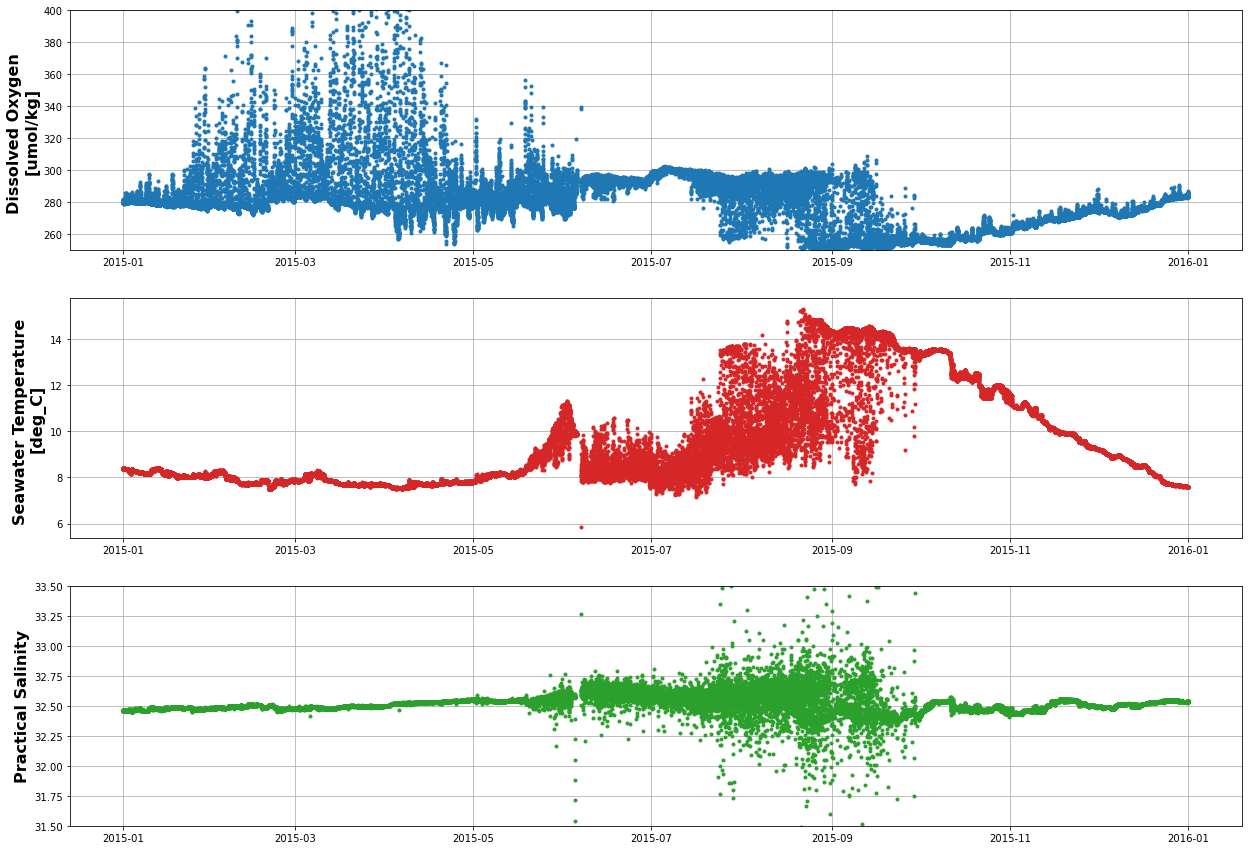

In [43]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(21,15))

ax[0].plot(df["time"], df["dissolved_oxygen"], marker=".", linestyle="", color="tab:blue")
ax[0].set_ylabel("Dissolved Oxygen \n[umol/kg]", fontsize=16, weight="bold")
ax[0].set_ylim((250, 400))
ax[0].grid()

ax[1].plot(df["time"], df["ctdmo_ghqr_sio_mule_instrument-ctdmo_seawater_temperature"], marker=".", linestyle="", color="tab:red")
ax[1].set_ylabel("Seawater Temperature \n[deg_C]", fontsize=16, weight="bold")
ax[1].grid()

ax[2].plot(df["time"], df["ctdmo_ghqr_sio_mule_instrument-practical_salinity"], marker=".", linestyle="", color="tab:green")
ax[2].set_ylabel("Practical Salinity", fontsize=16, weight="bold")
ax[2].set_ylim((31.5, 33.5))
ax[2].grid()

Looking at the data, there seems to be a lot of noise in the oxygen data from the first 5 months of 2015, while there is a lot of noise from June - October in the salinity and temperature data. Wonder what could be going on? The first place to check are the **annotations**.

---
## Annotations
Annotations are technical notes or qualitative data assessments of the instrument added by staff from the institutions operating the sensors. They represent the first human-in-the-loop (HITL) quality control review of the data coming from the sensor, and may contain important information about the state of the instrument, such as the presence of biofouling, power issues, communications disruptions, and other such issues. 

Annotations are ideal for removing known and identified bad data from a dataset before further processing. While it is not within the purview of OOI to comprehensively flag all such issues, such that additional end user QA/QC is required, existing annotations will provide valuable and time-saving information to support end user analysis.

An annotation downloaded from the OOI Data Portal is associated with a particular reference designator and not an individual instrument. It may also be further limited to a particular stream for a given reference designator, such as the pco2w_abc_dcl_instrument_recovered for recovered data from the SAMI-pCO2 instrument, as well as further limited to particular parameters. Annotations are either open-ended, with a start time (beginDT) and no end time (endDT), or may have both a start and end time. Times are returned in unix epoch microseconds. Lastly, a qcFlag may be assigned to a particular annotation following the QARTOD flagging conventions described above. 

In [44]:
print(f"The annotation endpoint is: {URLS['anno']}")

The annotation endpoint is: https://ooinet.oceanobservatories.org/api/m2m/12580/anno/find


Now construct the annotation request. Once we get the annotations, we have to convert the beginDT and endDT from the unix epoch time milliseconds into a readable time stamp:

In [45]:
params = {
    "beginDT": "2015-01-01T00:00:01.000Z",
    "endDT": "2016-01-01T00:00:01.000Z",
}

annotations = get_annotations(refdes, beginDT="2015-01-01T00:00:01.000Z", endDT="2016-01-01T00:00:01.000Z")
annotations["beginDT"] = annotations["beginDT"].apply(lambda x: convert_time(x))
annotations["endDT"] = annotations["endDT"].apply(lambda x: convert_time(x))
annotations
annotations

,@class,id,subsite,node,sensor,method,stream,beginDT,endDT,annotation,exclusionFlag,source,qcFlag,parameters
0,.AnnotationRecord,152,GP03FLMA,None,None,None,None,2015-06-06 22:40:00,2016-06-28 19:10:00,Deployment 3: Mooring was deployed 10-15m deep...,False,lgarzio@marine.rutgers.edu,0,[]
1,.AnnotationRecord,151,GP03FLMA,None,None,None,None,2014-06-17 06:00:00,2015-06-05 00:00:00,Deployment 2: Mooring was deployed 15-20m shal...,False,lgarzio@marine.rutgers.edu,0,[]
2,.AnnotationRecord,775,GP03FLMA,RIS01,03-DOSTAD000,None,None,2015-01-01 00:00:00,2015-06-05 00:00:00,Deployment 2: Dissolved oxygen noise increased...,False,lgarzio@marine.rutgers.edu,3,[]


Print out the annotation text for each row in the table above:

In [46]:
for index in annotations.index:
    start, stop, anno = annotations.loc[index, "beginDT"], annotations.loc[index, "endDT"], annotations.loc[index, "annotation"]
    print(f"{start} to {stop}: {anno}")

2015-06-06 22:40:00 to 2016-06-28 19:10:00: Deployment 3: Mooring was deployed 10-15m deeper than planned.
2014-06-17 06:00:00 to 2015-06-05 00:00:00: Deployment 2: Mooring was deployed 15-20m shallower than planned. Upon recovery of platform, biofouling was apparent on shallow CTDs.
2015-01-01 00:00:00 to 2015-06-05 00:00:00: Deployment 2: Dissolved oxygen noise increased, possibly from biofouling.


So now the noise in the oxygen data makes sense. There was biofouling! 

---
## Asynchronous Data Request

Asynchronous data request are not limited in the number of data points that you can request. Additionally, they allow you to request **netCDF** and **csv** data formats as well as **JSON**. However, they are slower than synchronous data requests and, depending on the dataset, can be very very large. The available request specificiations include:
* limit (required): if not specified, defaults netCDF 
* beginDT (optional): start date as YYYY-mm-ddTHH:MM:SS.fffZ format
* endDT (optional): end date in same format as beginDT
* parameters (optional): numeric IDs of which parameters to get 
* include_provenance (optional, default False): include a provenance file which specifies data processing paths
* include_annotations (optional, default False): include a file with data annotations 

For the example we walked through above with the synchronous request, we can similarly request the asynchronous version to get netCDF datasets. Our specifications will be:
* beginDT: 2015-01-01T00:00:00.000Z
* endDT: 2016-01-01T00:00:00.000Z
* parameters: 7 (time), 14 (dissolved oxygen)


In [47]:
# Asynchronous 
data_url = "/".join((URLS["data"], site, node, sensor, method, stream))

params = {
    "beginDT": "2015-01-01T00:00:01.000Z",
    "endDT": "2016-01-01T00:00:01.000Z",
    "parameters": "7,14"
}

In [48]:
from halo import HaloNotebook
import time

In [49]:
with HaloNotebook(text="Waiting for request to process", spinner="clock"):
    # Get the urls
    urls = get_api(data_url, params=params)
    # Check the status of the dataset preparation
    status_url = [url for url in urls["allURLs"] if re.match(r'.*async_results.*', url)][0]
    status_url = status_url + "/status.txt"
    status = SESSION.get(status_url)
    # Hold until the dataset construction is finished
    while status.status_code != requests.codes.ok:
        time.sleep(2)
        status = SESSION.get(status_url)
        
# Now fetch the thredds_url from the 
for d in urls['allURLs']:
    if 'thredds' in d:
        thredds_url = d

thredds_url

Output()

'https://opendap-west.oceanobservatories.org/thredds/catalog/ooi/areed@whoi.edu/20220607T163253972Z-GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered/catalog.html'

Now, the url we want is the "thredds catalog" in the 'allURLs' dictionary entry above. We have to parse out the catalog for the netCDF files

In [50]:
from bs4 import BeautifulSoup

In [51]:
page = requests.get(thredds_url).text
soup = BeautifulSoup(page, "html.parser")
pattern = re.compile('.*\\.nc$')
catalog = sorted([node.get('href') for node in soup.find_all('a', text=pattern)])
catalog

['catalog.html?dataset=ooi/areed@whoi.edu/20220607T163253972Z-GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered/deployment0002_GP03FLMA-RIM01-02-CTDMOG040-recovered_host-ctdmo_ghqr_sio_mule_instrument_20150101T000001-20150604T230001.nc',
 'catalog.html?dataset=ooi/areed@whoi.edu/20220607T163253972Z-GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered/deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150101T000056-20150125T234501.nc',
 'catalog.html?dataset=ooi/areed@whoi.edu/20220607T163253972Z-GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered/deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150126T000046-20150222T234501.nc',
 'catalog.html?dataset=ooi/areed@whoi.edu/20220607T163253972Z-GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered/deployment0002_GP03FLMA-RIS01-03-DOS

However, notice that there are some datasets which are NOT oxygen data. These include CTDMOG040, which supplies the practical salinity and temperature data necessary for calculating the oxygen concentration, and a FLORT datastream. We'll parse those out of the catalog and leave us with just the DOSTA datasets.

In [52]:
# Get rid of the unwanted datasets
catalog = [x for x in catalog if refdes in x.split("/")[-1]] 
catalog

['catalog.html?dataset=ooi/areed@whoi.edu/20220607T163253972Z-GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered/deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150101T000056-20150125T234501.nc',
 'catalog.html?dataset=ooi/areed@whoi.edu/20220607T163253972Z-GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered/deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150126T000046-20150222T234501.nc',
 'catalog.html?dataset=ooi/areed@whoi.edu/20220607T163253972Z-GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered/deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150223T000035-20150322T234501.nc',
 'catalog.html?dataset=ooi/areed@whoi.edu/20220607T163253972Z-GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered/deployment0002_GP03FLMA-RIS01

In order to download the data, we want to get the catalog files from the **fileServer** url. Then we can download the netCDF files to whatever directory we want.

In [53]:
from urllib.request import urlretrieve

In [54]:
# To download, we need the fileServer
fileServer = URLS["fileServer"]
netCDF_files = [re.sub("catalog.html\?dataset=", fileServer, file) for file in catalog]

# Make a save directory
saveDir = f"../data/{refdes}/"
if not os.path.exists(saveDir):
    os.makedirs(saveDir)

for file in netCDF_files:
        filename = file.split("/")[-1]
        saveFile = "/".join((saveDir, filename))
        print(f"Saving {filename} to {saveFile} \n")
        urlretrieve(file, saveFile)

Saving deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150101T000056-20150125T234501.nc to ../data/GP03FLMA-RIS01-03-DOSTAD000//deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150101T000056-20150125T234501.nc 

Saving deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150126T000046-20150222T234501.nc to ../data/GP03FLMA-RIS01-03-DOSTAD000//deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150126T000046-20150222T234501.nc 

Saving deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150223T000035-20150322T234501.nc to ../data/GP03FLMA-RIS01-03-DOSTAD000//deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150223T000035-20150322T234501.nc 

Saving deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-do

#### Packaged functions
The steps outlined above have been simplified into several easier-to-use functions as part of the package with this tutorial.

In [55]:
# First, get the thredds_url
thredds_url = get_thredds_url(refdes, method, stream, goldCopy=False, beginDT=params["beginDT"], endDT=params["endDT"], parameters=params["parameters"])

# Second, access the catalog
catalog = get_thredds_catalog(thredds_url)

# Next , get rid of the unwanted datasets
catalog = [x for x in catalog if refdes in x.split("/")[-1]] 

# Lastly, download the datasets
saveDir = f"../data/{refdes}/"
download_netCDF_files(catalog, goldCopy=False, saveDir=saveDir)

Output()

Output()

Saving deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150101T000056-20150125T234501.nc to ../data/GP03FLMA-RIS01-03-DOSTAD000//deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150101T000056-20150125T234501.nc 

Saving deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150126T000046-20150222T234501.nc to ../data/GP03FLMA-RIS01-03-DOSTAD000//deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150126T000046-20150222T234501.nc 

Saving deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150223T000035-20150322T234501.nc to ../data/GP03FLMA-RIS01-03-DOSTAD000//deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150223T000035-20150322T234501.nc 

Saving deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-do

---
## Loading Data (TODO)

There are several ways to open the data. You might be tempted to utilize ```xarray.open_mfdataset``` feature to open all of the datasets at once into a single file. This will fail because moorings are deployed such that the new mooring goes into the water before the old mooring is recovered, leading to overlapping time periods. The ```open_mfdataset``` function requires increasing primary dimension. This can be avoided by using a ```preprocess``` routine to trim the overlapping portions of the datasets, but then you potentially lose some valuable data when two instruments are in the water at the same time! 

Instead, we can concatentate the datasets together. However, this is recommended only with smaller datasets; long timeseries or large datasets, especially profilers, will cause you to run out of working memory.

In [ ]:
netCDF_files = ["/".join((saveDir, x)) for x in sorted(os.listdir(saveDir))]
for file in netCDF_files:
    ds = xr.open_dataset(file)
    ds = ds.swap_dims({"obs":"time"})
    try:
        new_ds = xr.concat([new_ds, ds], dim="time")
    except:
        new_ds = ds

In [ ]:
new_ds = new_ds.sortby("time")
new_ds

Working on fixing a couple of the ooi-data-exploration bugs with loading data wrt to limited parameter datasets.

In [ ]:
os.listdir("data/GP03FLMA-RIS01-03-DOSTAD000")

In [ ]:
sys.path.append("/home/areed/Documents/OOI/oceanobservatories/ooi-data-explorations/python/")

In [ ]:
from ooi_data_explorations.uncabled import process_dosta

In [ ]:
ds = xr.open_dataset("data/GP03FLMA-RIS01-03-DOSTAD000/deployment0002_GP03FLMA-RIS01-03-DOSTAD000-recovered_host-dosta_abcdjm_sio_instrument_recovered_20150101T000056-20150125T234501.nc")

In [ ]:
process_dosta.dosta_datalogger(ds)

In [ ]:
rename = {
    'estimated_oxygen_concentration': 'oxygen_concentration',
    'estimated_oxygen_saturation': 'oxygen_saturation',
    'dosta_abcdjm_cspp_tc_oxygen': 'svu_oxygen_concentration',
    'dosta_abcdjm_cspp_tc_oxygen_qc_executed': 'svu_oxygen_concentration_qc_executed',
    'dosta_abcdjm_cspp_tc_oxygen_qc_results': 'svu_oxygen_concentration_qc_results',
    'dissolved_oxygen': 'oxygen_concentration_corrected',
    'dissolved_oxygen_qc_executed': 'oxygen_concentration_corrected_qc_executed',
    'dissolved_oxygen_qc_results': 'oxygen_concentration_corrected_qc_results',
    'int_ctd_pressure': 'seawater_pressure',
    'temp': 'seawater_temperature',
}

In [ ]:
# First need to switch out 

In [ ]:
for var in ds.variables:
    if var in rename.keys():
        print(var)
        ds = ds.rename({var: rename.get(var)})

In [ ]:
ds